<a href="https://colab.research.google.com/github/intelligenxe/backtesting/blob/main/Backtesting_py_basic_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Backtesting.py_
=======================

_Backtesting.py_  doesn't really support stock picking or trading strategies that rely on arbitrage or multi-asset portfolio rebalancing; instead, it works with an individual tradeable asset at a time and is best suited for optimizing position entrance and exit signal strategies, and decisions upon values of technical indicators.

## Data

Backtesting ingests _all kinds of
[OHLC](https://en.wikipedia.org/wiki/Open-high-low-close_chart)
data_ (stocks, forex, futures, crypto, ...) as a
[pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/10min.html)
with columns `'Open'`, `'High'`, `'Low'`, `'Close'` and (optionally) `'Volume'`.
Such data is widely obtainable, e.g. with packages:
* [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/),
* [Quandl](https://www.quandl.com/tools/python),
* [findatapy](https://github.com/cuemacro/findatapy),
* [yFinance](https://github.com/ranaroussi/yfinance),
* [investpy](https://investpy.readthedocs.io/),
  etc.

Besides these columns, **your data frames can have additional columns which are accessible in your strategies in a similar manner**.

DataFrame should ideally be indexed with a _datetime index_ (convert it with [`pd.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html));
otherwise a simple range index will do.

In [ ]:
import yfinance as yf
import pandas as pd


In [ ]:
df = yf.download('TQQQ', start='2019-01-01')       # insert stock ticker and start of the date range

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df = df.drop('Adj Close', axis=1)

In [ ]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,8.695000,9.557500,8.682500,9.392500,135832800
2019-01-03,8.995000,9.102500,8.407500,8.482500,165255200
2019-01-04,8.887500,9.690000,8.792500,9.567500,136482000
2019-01-07,9.617500,10.037500,9.532500,9.872500,106553200
2019-01-08,10.172500,10.277500,9.725000,10.157500,105811200
...,...,...,...,...,...
2024-02-05,57.189999,57.419998,55.570000,56.950001,69973900
2024-02-06,57.380001,57.639999,55.639999,56.619999,70062100
2024-02-07,57.689999,58.660000,57.169998,58.310001,65911700


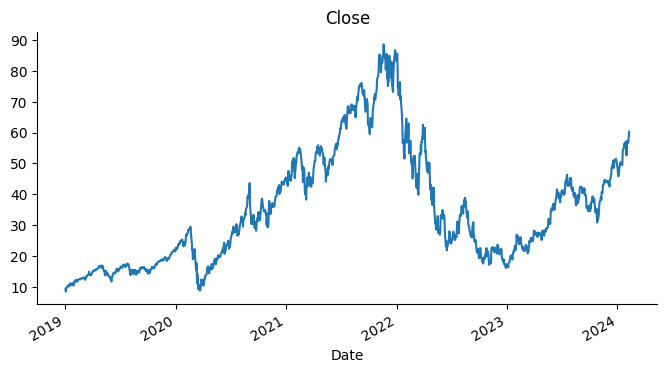

In [ ]:
from matplotlib import pyplot as plt
df['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

## Install backtesting

In [ ]:
!pip install backtesting

## Strategy

Let's create our strategy to backtest on the above data, a simple [moving average (MA) cross-over strategy](https://en.wikipedia.org/wiki/Moving_average_crossover).

_Backtesting.py_ doesn't ship its own set of _technical analysis indicators_. Users favoring TA should probably refer to functions from proven indicator libraries, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib) or
[Tulipy](https://tulipindicators.org),
but for this example, we can define a simple helper moving average function ourselves:

In [ ]:
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

A new strategy needs to extend
[`Strategy`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy)
class and override its two abstract methods:
[`init()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.init) and
[`next()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.next).

Method `init()` is invoked before the strategy is run. Within it, one ideally precomputes in efficient, vectorized manner whatever indicators and signals the strategy depends on.

Method `next()` is then iteratively called by the
[`Backtest`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest)
instance, once for each data point (data frame row), simulating the incremental availability of each new full candlestick bar.

Note, _backtesting.py_ cannot make decisions / trades _within_ candlesticks — any new orders are executed on the next candle's _open_ (or the current candle's _close_ if
[`trade_on_close=True`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.__init__)).
If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin with more fine-grained (e.g. hourly) data.

In [ ]:
from backtesting import Strategy
from backtesting.lib import crossover


class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 10                                           # n1 may be optimized
    n2 = 20                                           # n2 may be optimized

    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)

    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
# Note that self represents the instance (or object) of class. This handy keyword allows you to access variables, attributes, and methods of a defined class in Python.
# This self represents the object of the class itself
# The python __init__ method is declared within a class and is used to initialize the attributes of an object as soon as the object is formed (the above init method is not
# to be confused with the python __init__ )


In `init()` as well as in `next()`, the data the strategy is simulated and is available as an instance variable
[`self.data`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.data).

In `init()`, we declare and **compute indicators indirectly by wrapping them in
[`self.I()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.I)**.
The wrapper is passed a function (our `SMA` function) along with any arguments to call it with (our _close_ values and the MA lag). Indicators wrapped in this way will be automatically plotted, and their legend strings will be intelligently inferred.

In `next()`, we simply check if the faster moving average just crossed over the slower one. If it did and upwards, we close the possible short position and go long; if it did and downwards, we close the open long position and go short. Note, we don't adjust order size, so _Backtesting.py_ assumes _maximal possible position_. We use
[`backtesting.lib.crossover()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.crossover)
function instead of writing more obscure and confusing conditions, such as:

In [ ]:
%%script echo
# the above cell magic makes this cell to run like text
    def next(self):
        if (self.sma1[-2] < self.sma2[-2] and
                self.sma1[-1] > self.sma2[-1]):
            self.position.close()
            self.buy()

        elif (self.sma1[-2] > self.sma2[-2] and    # Ugh!
              self.sma1[-1] < self.sma2[-1]):
            self.position.close()
            self.sell()

In `init()`, the whole series of points was available, whereas **in `next()`, the length of `self.data` and all declared indicators is adjusted** on each `next()` call so that `array[-1]` (e.g. `self.data.Close[-1]` or `self.sma1[-1]`) always contains the most recent value, `array[-2]` the previous value, etc. (ordinary Python indexing of ascending-sorted 1D arrays).

**Note**: `self.data` and any indicators wrapped with `self.I` (e.g. `self.sma1`) are NumPy arrays for performance reasons. If you prefer pandas Series or DataFrame objects, use `Strategy.data.<column>.s` or `Strategy.data.df` accessors respectively. You could also construct the series manually, e.g. `pd.Series(self.data.Close, index=self.data.index)`.

We might avoid `self.position.close()` calls if we primed the
[`Backtest`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest)
instance with `Backtest(..., exclusive_orders=True)`.

## Backtesting

Let's see how our strategy performs on historical the above stock data. The
[`Backtest`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest)
instance is initialized with OHLC data and a strategy _class_ (see API reference for additional options), and we begin with 10,000 units of cash and set broker's commission to realistic 0.2%.

In [ ]:
from backtesting import Backtest

bt = Backtest(df, SmaCross, cash=10_000, commission=.002)
stats = bt.run()
stats
# Important stats:
#
# Duration
# Exposure Time [%]
#
# Return [%]
# Buy & Hold Return [%]
# Return (Ann.) [%]

Start                     2019-01-02 00:00:00
End                       2024-02-09 00:00:00
Duration                   1864 days 00:00:00
Exposure Time [%]                   93.001555
Equity Final [$]                 12888.764137
Equity Peak [$]                  38980.922469
Return [%]                          28.887641
Buy & Hold Return [%]              541.682203
Return (Ann.) [%]                    5.098523
Volatility (Ann.) [%]               78.660218
Sharpe Ratio                         0.064817
Sortino Ratio                        0.109546
Calmar Ratio                         0.070577
Max. Drawdown [%]                  -72.240302
Avg. Drawdown [%]                  -13.536496
Max. Drawdown Duration      697 days 00:00:00
Avg. Drawdown Duration       58 days 00:00:00
# Trades                                   52
Win Rate [%]                        40.384615
Best Trade [%]                     152.541047
Worst Trade [%]                    -31.754574
Avg. Trade [%]                    

[`Backtest.run()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.run)
method returns a pandas Series of simulation results and statistics associated with our strategy.

[`Backtest.plot()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.plot)
method provides the same insights in a more visual form.

In [ ]:
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p2290', ...)

## Optimization

We hard-coded the two lag parameters (`n1` and `n2`) into our strategy above. However, the strategy may work better with 15–30 or some other cross-over. **We declared the parameters as optimizable by making them [class variables](https://docs.python.org/3/tutorial/classes.html#class-and-instance-variables)**.

We optimize the two parameters by calling
[`Backtest.optimize()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize)
method with each parameter a keyword argument pointing to its pool of possible values to test. Parameter `n1` is tested for values in range between 5 and 30 and parameter `n2` for values between 10 and 70, respectively. Some combinations of values of the two parameters are invalid, i.e. `n1` should not be _larger than_ or equal to `n2`. We limit admissible parameter combinations with an _ad hoc_ constraint function, which takes in the parameters and returns `True` (i.e. admissible) whenever `n1` is less than `n2`. Additionally, we search for such parameter combination that maximizes return over the observed period. We could instead choose to optimize any other key from the returned `stats` series.

In [ ]:
%%time

stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 233 ms, sys: 42.3 ms, total: 276 ms
Wall time: 8.43 s


Start                     2019-01-02 00:00:00
End                       2024-02-09 00:00:00
Duration                   1864 days 00:00:00
Exposure Time [%]                   93.157076
Equity Final [$]                 70170.276397
Equity Peak [$]                    80507.2054
Return [%]                         601.702764
Buy & Hold Return [%]              541.682203
Return (Ann.) [%]                   46.490404
Volatility (Ann.) [%]               100.38469
Sharpe Ratio                         0.463122
Sortino Ratio                        1.123175
Calmar Ratio                         0.848719
Max. Drawdown [%]                  -54.777141
Avg. Drawdown [%]                   -9.877712
Max. Drawdown Duration      411 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
# Trades                                   56
Win Rate [%]                             50.0
Best Trade [%]                     107.764402
Worst Trade [%]                    -30.492261
Avg. Trade [%]                    

We can look into `stats['_strategy']` to access the Strategy _instance_ and its optimal parameter values (n1 and n2 shown when you run the next cell below).

In [ ]:
stats._strategy

<Strategy SmaCross(n1=5,n2=20)>

In [ ]:
bt.plot(plot_volume=False, plot_pl=False)

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p2546', ...)

Often, strategy optimization manages to up its initial performance _on in-sample data_ and even beat simple
[buy & hold](https://en.wikipedia.org/wiki/Buy_and_hold).
In real life optimization, however, do **take steps to avoid
[overfitting](https://en.wikipedia.org/wiki/Overfitting)**.

## Trade data

In addition to backtest statistics returned by
[`Backtest.run()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.run)
shown above, you can look into _individual trade returns_ and the changing _equity curve_ and _drawdown_ by inspecting the last few, internal keys in the result series.

In [ ]:
stats.tail()

Expectancy [%]                                             5.382835
SQN                                                        0.953733
_strategy                                      SmaCross(n1=5,n2=20)
_equity_curve                       Equity  DrawdownPct Drawdown...
_trades               Size  EntryBar  ExitBar  EntryPrice  ExitP...
dtype: object

The columns should be self-explanatory.

In [ ]:
stats['_equity_curve']  # Contains equity/drawdown curves. DrawdownDuration is only defined at ends of DD periods.

,Equity,DrawdownPct,DrawdownDuration
2019-01-02,10000.000000,0.000000,NaT
2019-01-03,10000.000000,0.000000,NaT
2019-01-04,10000.000000,0.000000,NaT
2019-01-07,10000.000000,0.000000,NaT
2019-01-08,10000.000000,0.000000,NaT
...,...,...,...
2024-02-05,67699.238754,0.159091,NaT
2024-02-06,67307.196578,0.163961,NaT
2024-02-07,69314.919479,0.139022,NaT
2024-02-08,69600.036941,0.135481,NaT


In [ ]:
stats['_trades']  # Contains individual trade data

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-668,88,111,14.960020,14.482500,318.983156,0.031920,2019-05-09,2019-06-12,34 days
1,711,111,148,14.511465,14.485000,-18.816913,-0.001824,2019-06-12,2019-08-05,54 days
2,-712,148,170,14.456030,15.805000,-960.467101,-0.093315,2019-08-05,2019-09-05,31 days
3,589,170,186,15.836610,15.637500,-117.276082,-0.012573,2019-09-05,2019-09-27,22 days
4,-590,186,199,15.606225,16.305000,-412.277542,-0.044775,2019-09-27,2019-10-16,19 days
5,539,199,236,16.337610,19.272499,1581.905052,0.179640,2019-10-16,2019-12-09,54 days
6,-540,236,237,19.233954,19.112499,65.585619,0.006315,2019-12-09,2019-12-10,1 days
7,546,237,289,19.150724,22.320000,1730.424401,0.165491,2019-12-10,2020-02-26,78 days
8,-547,289,319,22.275360,13.172500,4979.264441,0.408652,2020-02-26,2020-04-08,42 days
9,1300,319,396,13.198845,27.422501,18490.752741,1.077644,2020-04-08,2020-07-29,112 days


Learn more by exploring further
[examples](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#tutorials)
or find more framework options in the
[full API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules).

Future work:
install TA-lib https://www.youtube.com/watch?v=AQFZMvYp2KA&t=0s  and practice
 https://www.youtube.com/watch?v=f2gxz8JbrlQ
Try all the backtesting features in  https://www.youtube.com/watch?v=e4ytbIm2Xg0
(00:16:59) Parameter Optimization
(00:22:52) Custom optimization metrics
(00:26:54) Organizing saved backtests
(00:30:22) Randomized Grid Search
(00:32:38) Parameter Optimization Heatmaps
(00:42:48) Multi-timeframe strategies
(00:49:13) Shorting, stop loss, take profit
(00:58:42) Order Sizing
(01:03:17) Extracting Trade Data
(01:05:23) Bar Since Function

Practice
https://www.youtube.com/watch?v=vPBwO6Fa6rc
Learn how to read the graphs
https://www.youtube.com/watch?v=FpSopSupizo














